# Asymmetric Gaussian Demo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from curvefit.core.functions import *
from curvefit.core.model import CurveModel

import warnings
warnings.filterwarnings('ignore')


## read in data

In [2]:
# get pops
pop_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_05_18_h0/model_data.csv')
pop_df = pop_df[['location_id', 'location_name', 'population']].drop_duplicates().reset_index(drop=True)

# get data
df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_05_18_h0/model_results.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.merge(pop_df)

# summarize
df['cumul_death_rate'] = df[[f'draw_{d}' for d in range(1000)]].mean(axis=1) / df['population']
df['daily_death_rate'] = np.nan
df['daily_death_rate'] = np.diff(df[[f'draw_{d}' for d in range(1000)]], axis=0).mean(axis=1) / df['population'][1:]
df.loc[df['date'] == df.groupby('location_id')['date'].transform(min), 'daily_death_rate'] = df['cumul_death_rate']
df['ln_death_rate'] = np.log(df['daily_death_rate'])
df = df.drop([f'draw_{d}' for d in range(1000)], axis=1)

# keep 80% reduction only
last_day_rate = (df.groupby('location_id')
                 .apply(lambda x: x.reset_index(drop=True).iloc[[-1]]['daily_death_rate'])
                 .reset_index())
last_day_rate = last_day_rate.rename(index=str, columns={'daily_death_rate':'last_day_rate'})
last_day_rate = last_day_rate[['location_id', 'last_day_rate']]
df['peak_rate'] = df.groupby('location_id')['daily_death_rate'].transform(max)
df = df.merge(last_day_rate)
df = df.loc[df['last_day_rate'] <= df['peak_rate'] * 0.2]

df['day0'] = df.groupby('location_id')['date'].transform(min)
df['days'] = df.apply(lambda x: (x['date'] - x['day0']).days, axis=1)
df['intercept'] = 1
df = df[['location_id', 'location_name', 'date', 'intercept', 'days', 'ln_death_rate', 'population']]


## Create and fit Curvefit model

In [3]:
def run_model(df):
    params = np.array([0.1, 50.0, 1.0, 0.5])
    param_names = ['alpha', 'beta', 'p', 'r']
    link_fun = [np.exp, lambda x: x, np.exp, np.exp]
    var_link_fun = [lambda x: x]*4
    fun = ln_asym_gaussian_pdf

    model = CurveModel(
        df,
        col_t='days',
        col_obs='ln_death_rate',
        col_covs=[['intercept'], ['intercept'], ['intercept'], ['intercept']],
        col_group='location_id',
        param_names=param_names,
        link_fun=link_fun,
        var_link_fun=var_link_fun,
        fun=fun
    )

    model.fit_params(fe_init=params,
                     fe_bounds=[[-np.inf, 0.0], [-np.inf, np.inf], [-np.inf, 0.0], [-np.inf, 0.0]],
                     re_bounds=[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]],
                     options={'disp': True})

    days = np.arange(120)
    pred = model.predict(days)

    plt.scatter(df['days'], np.exp(df['ln_death_rate']) * df['population'].values[0])
    plt.plot(days, np.exp(pred) * df['population'].values[0], color='red')
    plt.title(df['location_name'].values[0])
    plt.show()
    
    param_df = pd.DataFrame(dict(zip(param_names, model.params)))
    param_df['location_name'] = df['location_name'].values[0]
    
    return param_df


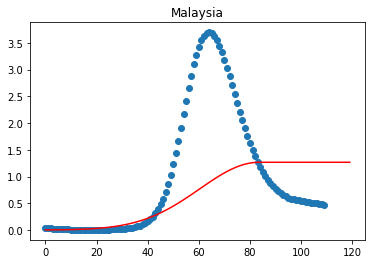

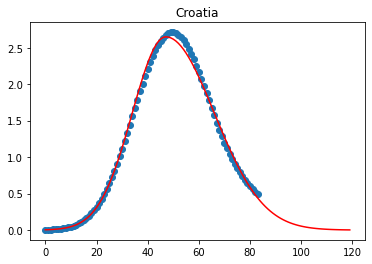

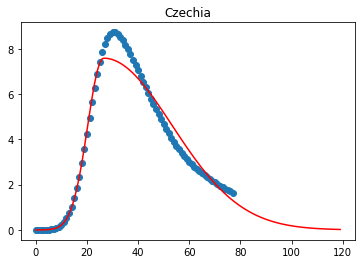

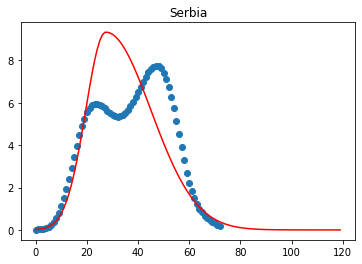

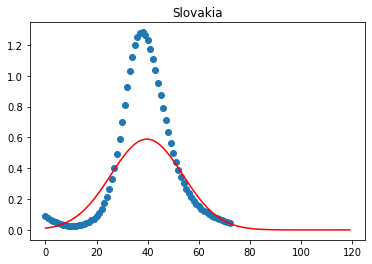

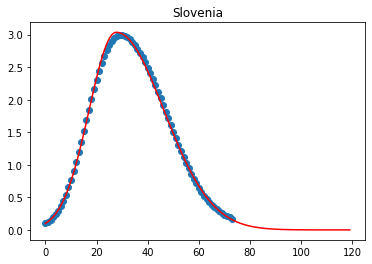

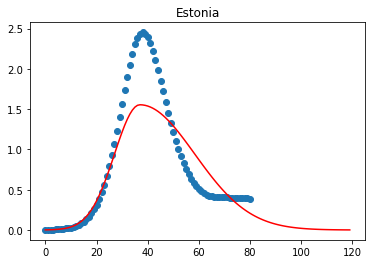

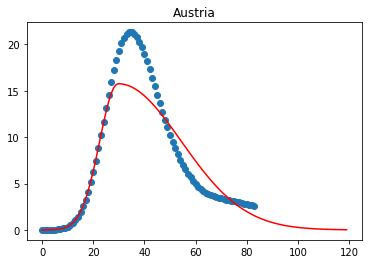

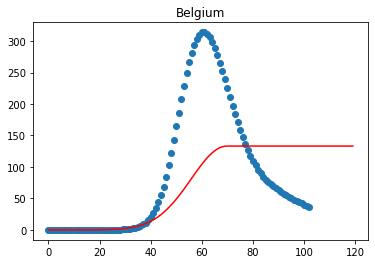

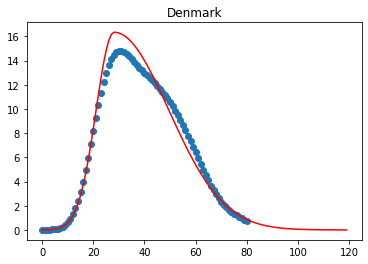

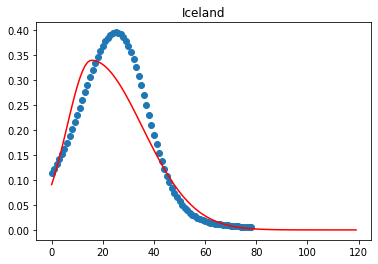

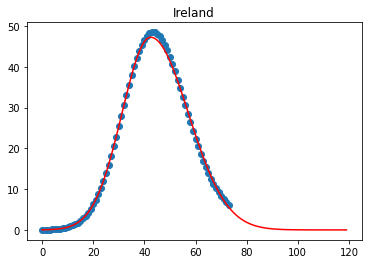

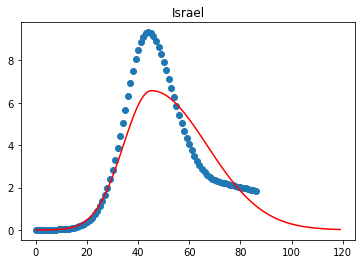

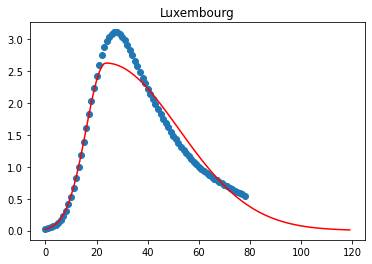

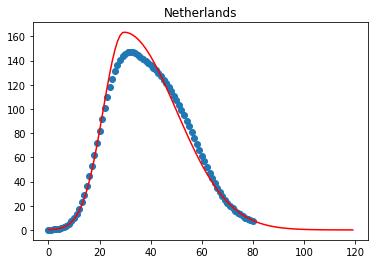

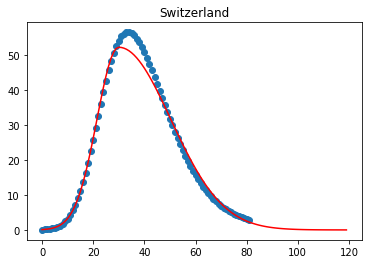

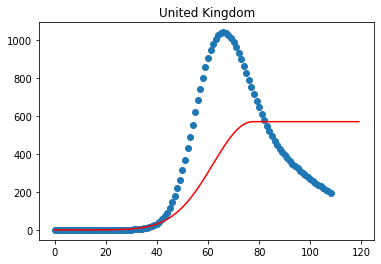

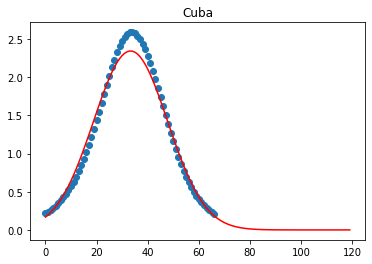

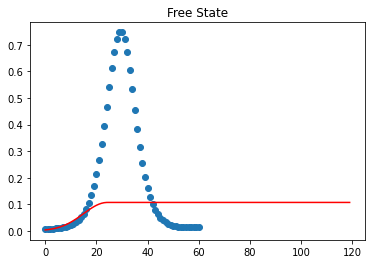

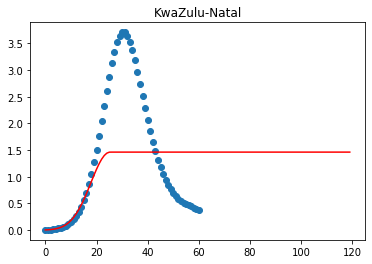

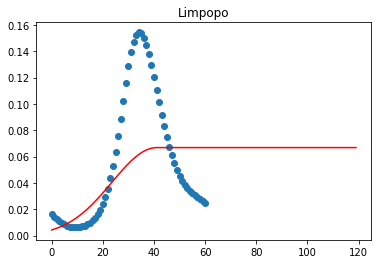

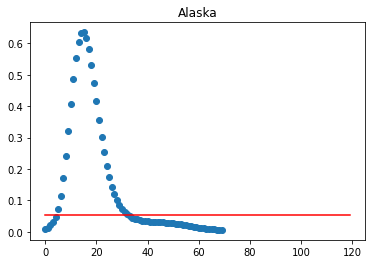

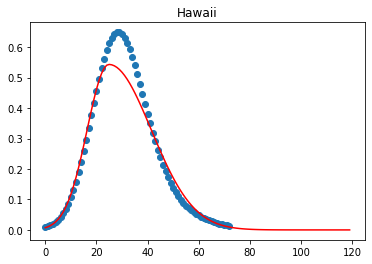

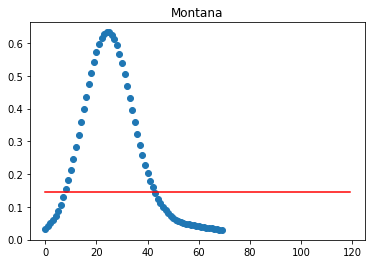

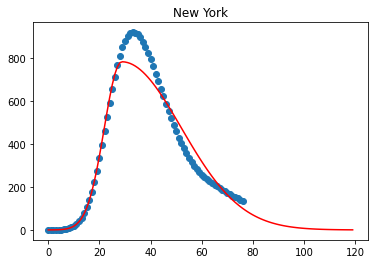

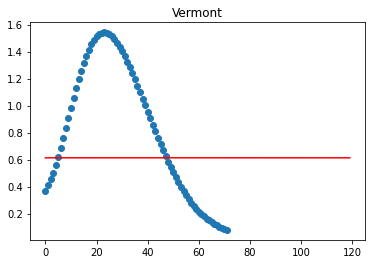

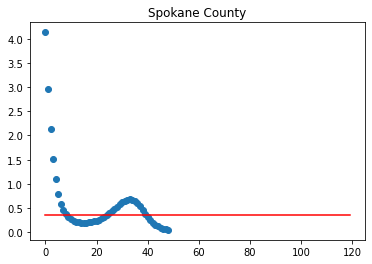

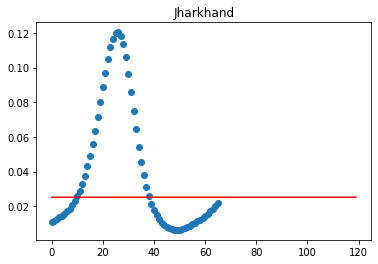

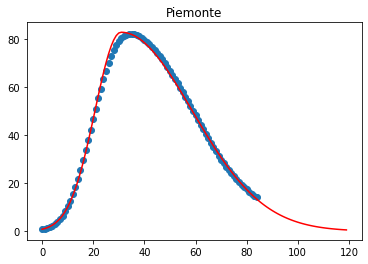

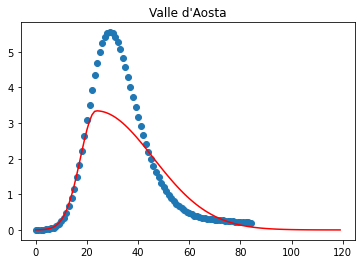

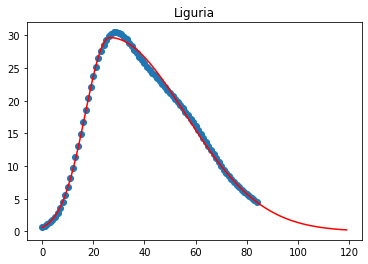

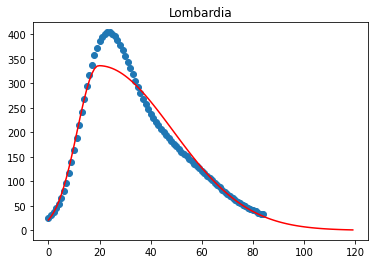

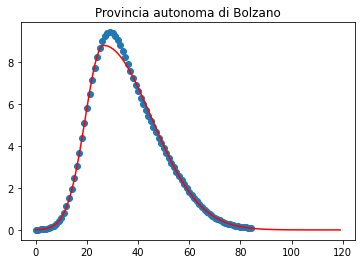

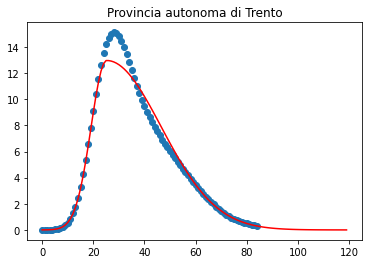

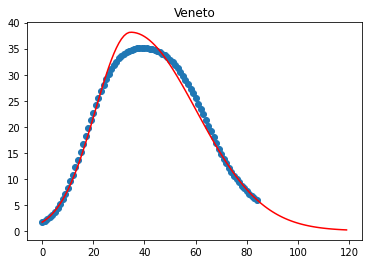

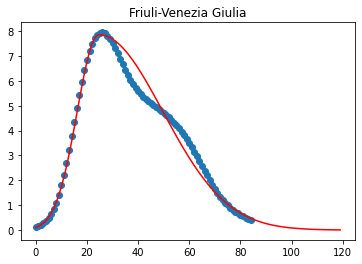

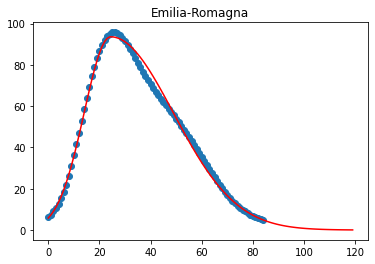

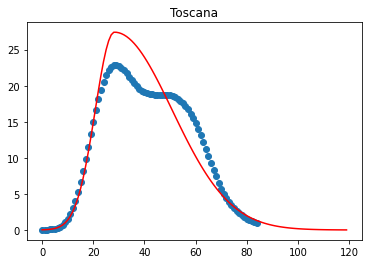

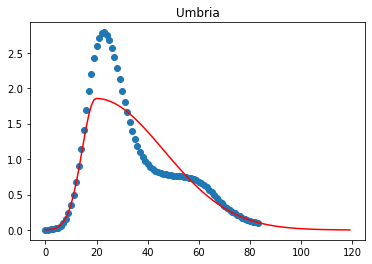

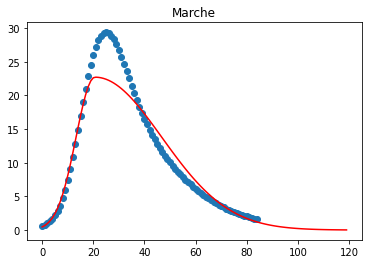

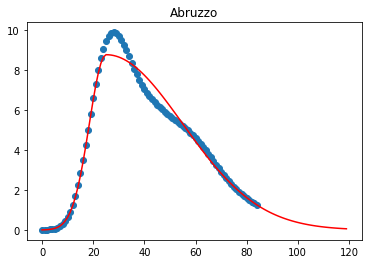

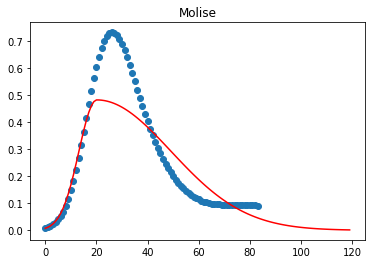

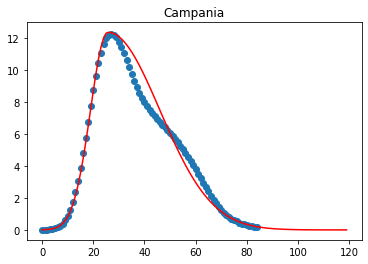

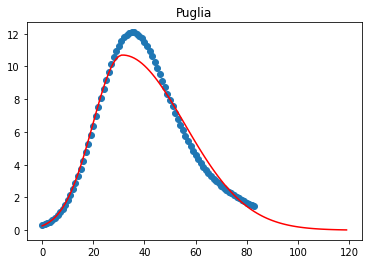

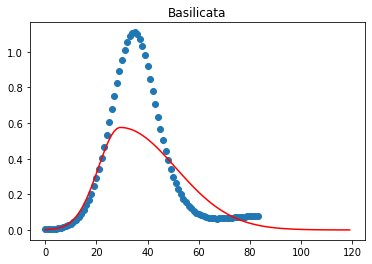

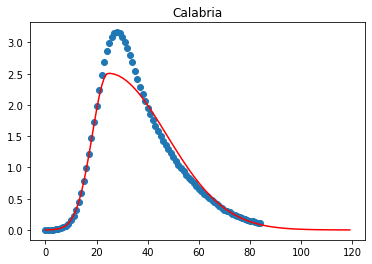

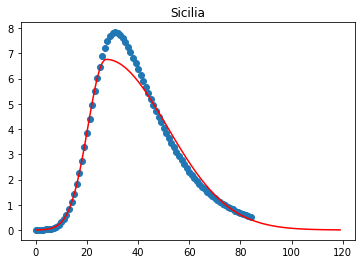

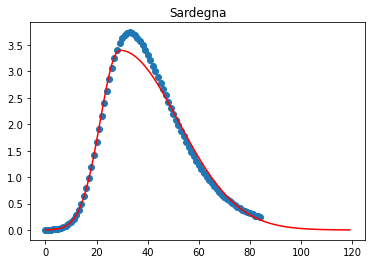

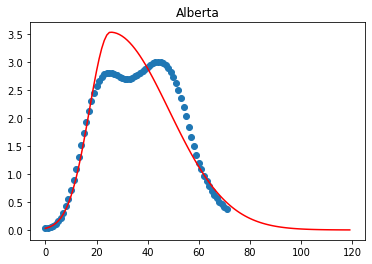

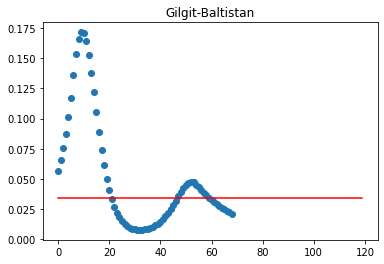

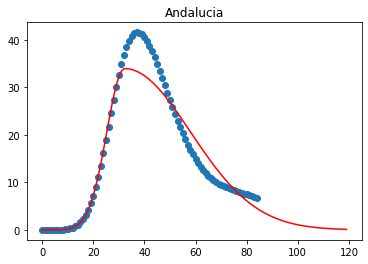

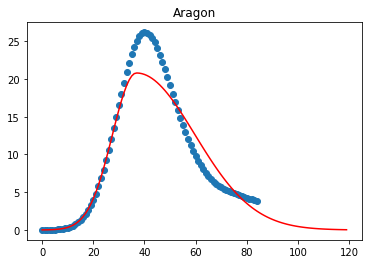

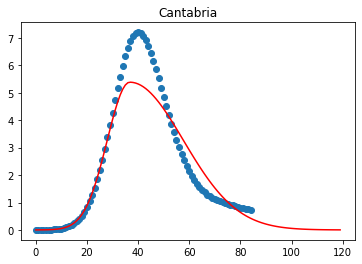

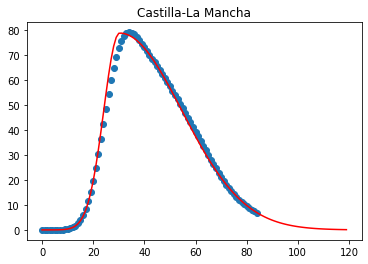

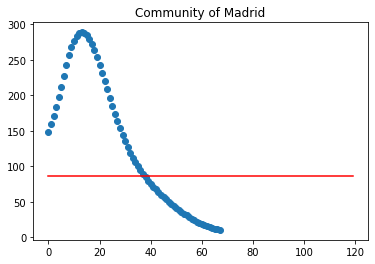

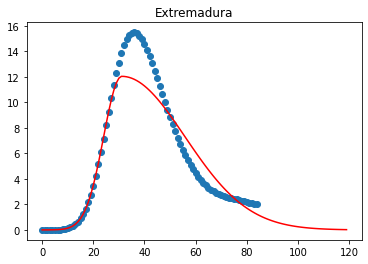

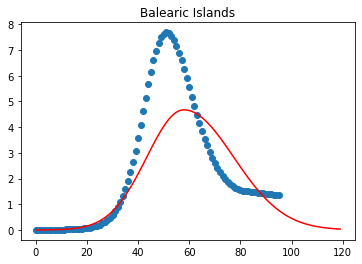

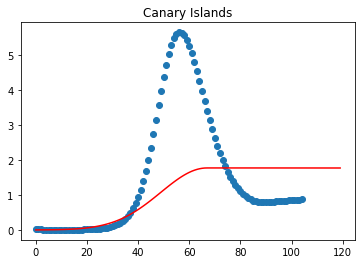

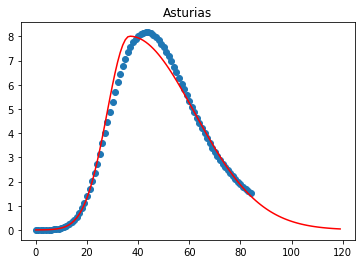

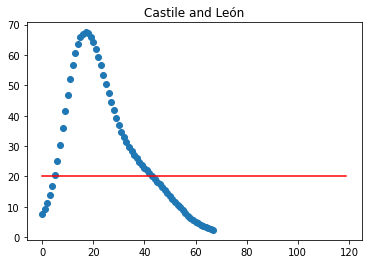

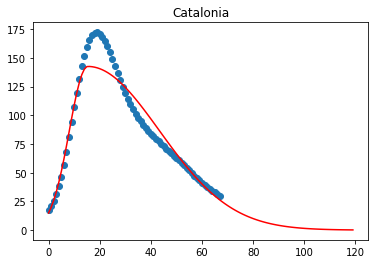

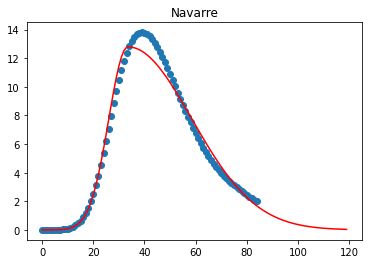

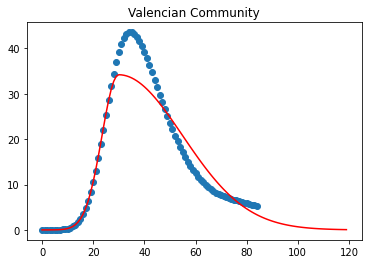

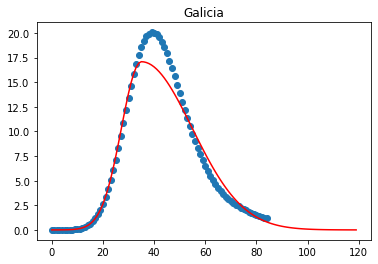

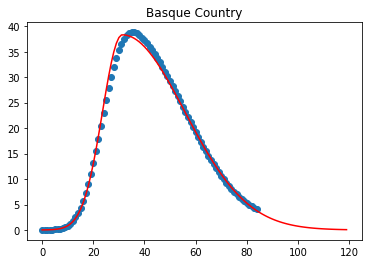

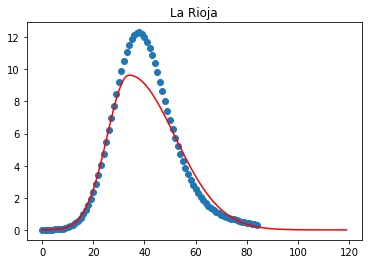

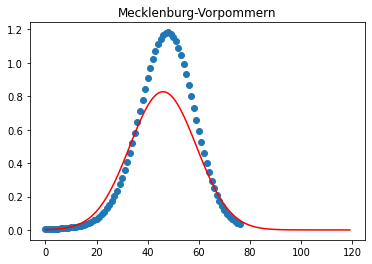

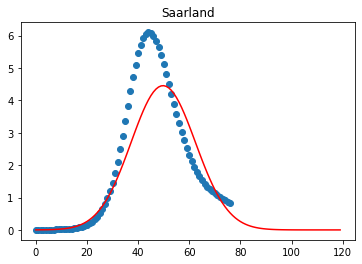

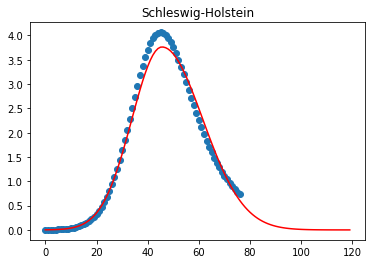

In [4]:
param_df = df.groupby('location_id').apply(lambda x: run_model(x)).reset_index(drop=True)
param_df = param_df[['location_name'] + param_df.columns.to_list()[:-1]]

In [5]:
param_df.loc[param_df['location_name'] == 'Ireland']

,location_name,alpha,beta,p,r
11,Ireland,0.063603,42.391856,0.000312,0.751458
